In [1]:
import numpy as np
import sys, os, glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp, pearsonr, ranksums, zscore
from scipy.stats.mstats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
import statsmodels.api as sm

sys.path.append('/Users/GA/Documents/Dayan_lab/Code/Eran_python/Fit_params')
from misc_analysis import get_Q_true, get_optimal_move, permutation_test, get_entropy, get_joint_entropy, histogram

In [2]:
# World 1
world1 = np.load('/Users/GA/Documents/Dayan_lab/Data/Eran/world1.npy')
world2 = np.load('/Users/GA/Documents/Dayan_lab/Data/Eran/world2.npy')
idcs1  = np.load('/Users/GA/Documents/Dayan_lab/Data/Eran/idcs1.npy')
idcs2  = np.load('/Users/GA/Documents/Dayan_lab/Data/Eran/idcs2.npy')

In [3]:
def bootstrap_test(X, Y, num_perm=10000):
    
    x_mean = np.mean(X)
    y_mean = np.mean(Y)
    
    shifted_Y = Y - y_mean + x_mean
    ny = len(shifted_Y)
    
    tests = []
    for i in range(num_perm):
        shuffY = np.random.choice(shifted_Y, size=ny, replace=True)
        tests += [np.mean(shuffY)]
        
    diff_count = len(np.where(tests >= x_mean)[0])
    p_value    = 1.0 - (float(diff_count)/float(num_perm))
    
    return tests, x_mean, p_value


### Generate flexibility idcs for simulated data

In [ ]:
k = np.zeros((40, 4))
for sub in range(40):

    root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/%u'%(sub)
    
    opt_moves11 = 0
    opt_moves12 = 0
    opt_moves21 = 0
    opt_moves22 = 0
    
    # iterate over 5 blocks
    for i in range(5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7
        tmp = []
        
        if i in [0, 1]:
            Q1_true, Q2_true = get_Q_true(world1, idcs1)
        elif i in [2, 3]:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)
        else:
            Q1_true, Q2_true = get_Q_true(world2, idcs2)
        
        for j in range(this_range):
    
            os.chdir(os.path.join(root_folder, str(i), str(j)))
            all_files = glob.glob('*.npz')

            # Sort files by episode number
            episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
            idcs     = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
            all_files_sorted = [all_files[i] for i in idcs] 
            
            for f in range(len(all_files_sorted)):
                this_file = all_files_sorted[f]
                data      = np.load(this_file)
                move      = data['move']
                
                if len(move) != 2:
                    s = move[0]
                    a = move[1]
                    if a in get_optimal_move(s, Q2_true):
                        opt_moves11 += 1
                    elif a in get_optimal_move(s, Q1_true)//4:
                        opt_moves12 += 1

                else:
                    s = move[0][0]
                    a = move[0][1]
                    if a in get_optimal_move(s, Q2_true):
                        opt_moves21 += 1
                    elif a in get_optimal_move(s, Q1_true)//4:
                        opt_moves22 += 1
    
    k[sub, :] = [opt_moves11/(18*5), opt_moves12/(18*5), opt_moves21/(36*5), opt_moves22/(36*5)]
    
for sub in range(40):
    np.save(os.path.join('/Users/GA/Documents/Dayan_lab/Data/Eran/subject_data', str(i), 'flexibility.npy'), k[sub, :])

### Get flexibility idcs 

In [ ]:
def get_flex_idcs(sub):
    
    root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/TTASKK/%u'%(sub)
    
    flex_idcs = []
    for rep in range(100):
    
        rep_folder  = os.path.join(root_folder, str(rep))

        opt_moves11 = 0
        opt_moves12 = 0
        opt_moves21 = 0
        opt_moves22 = 0

        # iterate over 5 blocks
        for i in range(5):
            if i == 0:
                this_range = 6
            else:
                this_range = 7
            tmp = []

            if i in [0, 1]:
                Q1_true, Q2_true = get_Q_true(world1, idcs1)
            elif i in [2, 3]:
                Q1_true, Q2_true = get_Q_true(world2, idcs1)
            else:
                Q1_true, Q2_true = get_Q_true(world2, idcs2)

            for j in range(this_range):

                moves = np.load(os.path.join(rep_folder, str(i), 'moves%u.npy'%j))

                for move in moves:

                    if len(move) != 2:
                        s = move[0]
                        a = move[1]
                        if a in get_optimal_move(s, Q2_true):
                            opt_moves11 += 1
                        elif a in get_optimal_move(s, Q1_true)//4:
                            opt_moves12 += 1

                    else:
                        s = move[0][0]
                        a = move[0][1]
                        if a in get_optimal_move(s, Q2_true):
                            opt_moves21 += 1
                        elif a in get_optimal_move(s, Q1_true)//4:
                            opt_moves22 += 1

        flex_idcs.append(opt_moves11/(18*5) - opt_moves12/(18*5) - opt_moves21/(36*5) + opt_moves22/(36*5))
    return flex_idcs

In [ ]:
Y = np.zeros((100, 40))
for i in range(40):
    Y[:, i] = get_flex_idcs(i)
    print('Done %u'%i)
np.save(os.path.join('/Users/GA/Documents/Dayan_lab/Data/Eran/flexibility/all_flex.npy'), Y)

### Load flexibility idcs

In [4]:
root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/subject_data'

flex_idcs_hums = np.zeros(40)
for i in range(40):
    tmp = np.load(os.path.join(root_folder, str(i), 'flexibility.npy'))
    flex_idcs_hums[i] = tmp[0]-tmp[1]+tmp[3]-tmp[2]

Y = np.load('/Users/GA/Documents/Dayan_lab/Data/Eran/flexibility/all_flex.npy')
flex_idcs_ag   = np.mean(Y, axis=0)

In [5]:
subs_who_replay = np.load(os.path.join('/Users/GA/Documents/Dayan_lab/Data/Eran/task/Analysis', 'subs_who_replay.npy'))
vals = np.load(os.path.join('/Users/GA/Documents/Dayan_lab/Data/Eran/task/Analysis', 'value_objective.npy'))

### Regression human IF vs simulated IF

34
38


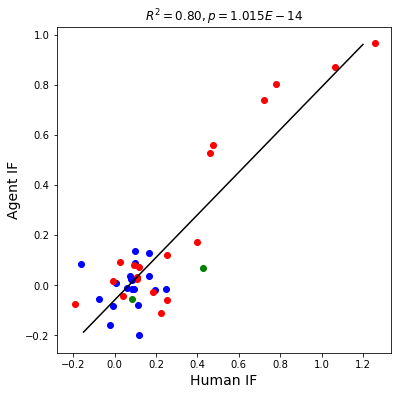

In [11]:
reg = LinearRegression().fit(flex_idcs_hums.reshape(-1, 1), np.array(flex_idcs_ag).reshape(-1,1))

x_pred = np.linspace(-0.15, 1.2, 20)
y_pred = reg.predict(x_pred.reshape(-1, 1))
rr, pr = pearsonr(flex_idcs_hums, flex_idcs_ag)

figure = plt.figure(figsize=(6, 6))

for i in range(40):
    if i in subs_who_replay:
        if i in subs_who_replay[np.argwhere(vals < 0).flatten()]:
            plt.scatter(flex_idcs_hums[i], flex_idcs_ag[i], c='green')
            print(i)
        else:
            plt.scatter(flex_idcs_hums[i], flex_idcs_ag[i], c='r')
    else:
        plt.scatter(flex_idcs_hums[i], flex_idcs_ag[i], c='b')
plt.plot(x_pred, y_pred, c='k')
plt.xlabel('Human IF', fontsize=14)
plt.ylabel('Agent IF', fontsize=14)
plt.title(r'$R^{2}=%.2f, p=%.3E$'%(rr**2, pr));

flex_subs   = np.array([flex_idcs_ag[i] for i in subs_who_replay])
inflex_subs = np.array([flex_idcs_ag[i] for i in range(40) if i not in subs_who_replay])

# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp4/flex_idx.svg', transparent=True)

# d, t, p = permutation_test(inflex_subs, flex_subs, 100000, return_tests=True)
# with open('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp4/stats_flex_idx.txt', 'w') as f:
#     f.write('Regression: R^2 = %.3E, p = %.3E\n'%(rr**2, pr))
#     f.write('Inflex vs flex: t = %.3E, p = %.3E'%(t, p))

### Parameters IF analysis

In [6]:
params_path = '/Users/GA/Documents/Dayan_lab/Data/Eran/fits'

In [10]:
for i in subs_who_replay:
    p = np.load(os.path.join(params_path, 'save_params_%u'%i, 'params.npy'))[:18]
    print('subject: %u, tau^{MB}: %.2f, tau^{MF}: %.2f'%(i, p[8], p[9]))

subject: 0, tau^{MB}: 0.98, tau^{MF}: 0.97
subject: 2, tau^{MB}: 1.00, tau^{MF}: 0.80
subject: 3, tau^{MB}: 1.00, tau^{MF}: 0.62
subject: 5, tau^{MB}: 0.20, tau^{MF}: 0.91
subject: 6, tau^{MB}: 0.30, tau^{MF}: 0.95
subject: 8, tau^{MB}: 1.00, tau^{MF}: 1.00
subject: 14, tau^{MB}: 0.96, tau^{MF}: 0.93
subject: 16, tau^{MB}: 0.99, tau^{MF}: 0.77
subject: 17, tau^{MB}: 0.94, tau^{MF}: 0.93
subject: 19, tau^{MB}: 1.00, tau^{MF}: 0.76
subject: 21, tau^{MB}: 1.00, tau^{MF}: 0.79
subject: 24, tau^{MB}: 0.57, tau^{MF}: 0.85
subject: 26, tau^{MB}: 0.47, tau^{MF}: 0.87
subject: 27, tau^{MB}: 0.69, tau^{MF}: 0.93
subject: 28, tau^{MB}: 0.23, tau^{MF}: 0.89
subject: 29, tau^{MB}: 0.92, tau^{MF}: 0.34
subject: 32, tau^{MB}: 1.00, tau^{MF}: 0.65
subject: 34, tau^{MB}: 0.33, tau^{MF}: 0.93
subject: 35, tau^{MB}: 0.94, tau^{MF}: 0.97
subject: 37, tau^{MB}: 0.98, tau^{MF}: 0.89
subject: 38, tau^{MB}: 0.14, tau^{MF}: 0.97


In [ ]:
# subs = np.delete(range(40), subs_who_replay)
subs = subs_who_replay

# load params
# MB_params = [5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17]
MB_params = [5, 10, 11, 12, 13, 14]

labels = np.delete(range(18), MB_params)

X = np.zeros((len(subs), 18))
for i in range(X.shape[0]):
    p = np.load(os.path.join(params_path, 'save_params_%u'%subs[i], 'params.npy'))[:18]
    p[8] = (1-p[8])
    p[9] = (1-p[9])
    X[i, :] = p

# zscore
X = zscore(X, axis=0)
y = zscore(np.mean(Y[:, subs], axis=0))

X = pd.DataFrame(X, columns=[str(i) for i in range(18)])
X.drop([str(i) for i in MB_params], axis=1, inplace=True)

estimator = LinearRegression()
selector  = RFECV(estimator, min_features_to_select=4, step=1, cv=5)
selector  = selector.fit(X, y)

for i in range(len(selector.ranking_)):
    if selector.ranking_[i] != 1:
        X.drop(str(labels[i]), axis=1, inplace=True)
        
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

In [ ]:
coefs  = est2.params
labels = est2.params.index.astype(int)

sort_idcs  = np.argsort(np.abs(coefs))[::-1]

sorted_labels  = [labels[k] for k in sort_idcs]
sorted_coefs   = coefs[sort_idcs]
sorted_ci      = est2.conf_int(0.05).iloc[sort_idcs]

In [ ]:
figure = plt.figure(figsize=(7, 4))

plt.bar(range(len(sorted_labels)), sorted_coefs, width=0.7, facecolor='#4CBA64')
for i in range(len(sorted_labels)):
    x = [i, i]
    y = [sorted_ci[0].iloc[i], sorted_ci[1].iloc[i]]
    plt.plot(x, y, c='k')
    
plt.axhline(0, c='k')
plt.xticks(range(len(sorted_labels)), sorted_labels, fontsize=16);
plt.yticks(fontsize=14)
plt.ylabel('Relation to flexibility', fontsize=16)
# plt.ylim([-1.25, 1.25])

# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp4/inflex_coef.svg', transparent=True)
# with open('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp4/stats_coef_inflex.txt', 'w') as f:
#     f.write(est2.summary().as_text())

### Replay is sometimes bad...

In [19]:
subs = subs_who_replay

# load params
# MB_params = [5, 10, 11, 12, 13, 14]
MB_params = np.delete(range(18), [8, 9, 15])

labels = np.delete(range(18), MB_params)

X = np.zeros((len(subs), 18))
for i in range(X.shape[0]):
    p = np.load(os.path.join(params_path, 'save_params_%u'%subs[i], 'params.npy'))[:18]
    p[8] = (1-p[8])
    p[9] = (1-p[9])
    X[i, :] = p
    
# zscore
X = zscore(X, axis=0)
y = zscore(vals)

X = pd.DataFrame(X, columns=[str(i) for i in range(18)])
X.drop([str(i) for i in MB_params], axis=1, inplace=True)

est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.816
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                              26.60
Date:                Thu, 25 Mar 2021   Prob (F-statistic):                    7.79e-07
Time:                        17:47:41   Log-Likelihood:                         -12.025
No. Observations:                  21   AIC:                                      30.05
Df Residuals:                      18   BIC:                                      33.18
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
coefs  = est2.params
labels = est2.params.index.astype(int)

sort_idcs  = np.argsort(np.abs(coefs))[::-1]

sorted_labels  = [labels[k] for k in sort_idcs]
sorted_coefs   = coefs[sort_idcs]
sorted_ci      = est2.conf_int(0.05).iloc[sort_idcs]

In [ ]:
figure = plt.figure(figsize=(7, 4))

plt.bar(range(len(sorted_labels)), sorted_coefs, width=0.7, facecolor='#4CBA64')
for i in range(len(sorted_labels)):
    x = [i, i]
    y = [sorted_ci[0].iloc[i], sorted_ci[1].iloc[i]]
    plt.plot(x, y, c='k')
    
plt.axhline(0, c='k')
plt.xticks(range(len(sorted_labels)), sorted_labels, fontsize=16);
plt.yticks(fontsize=14)
plt.ylabel('Relation to replay benefit', fontsize=16)

plt.ylim([-1.3, 1.3])
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp4/vals_coef.svg', transparent=True)
with open('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp4/stats_coef_vals.txt', 'w') as f:
    f.write(est2.summary().as_text())

### Parameters MF and MB

In [ ]:
# load params
flex_tau, flex_rho, flex_xi   = [], [], []
inflex_tau, inflex_rho, inflex_xi = [], [], []

for i in range(40):
    p = np.load(os.path.join(params_path, 'save_params_%u'%i, 'params.npy'))[:18]
    if i in subs_who_replay:
        flex_tau.append(1-p[9])
        flex_rho.append(1-p[8])
        flex_xi.append(p[15])
    else:
        inflex_tau.append(1-p[9])
        inflex_rho.append(1-p[8])
        inflex_xi.append(p[15])

In [ ]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.bar([1], np.mean(flex_tau), facecolor='r', alpha=0.5)
plt.bar([2], np.mean(inflex_tau), facecolor='b', alpha=0.5)
for i in range(len(flex_tau)):
    if vals[i] < 0:
        plt.scatter([1.1], flex_tau[i], facecolor='green')
    else:
        plt.scatter([0.9], flex_tau[i], facecolor='r')
plt.scatter([2]*len(inflex_tau), inflex_tau, color='b')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
hurt_rho    = []
benefit_rho = []
plt.bar([1.5], np.mean(flex_rho), facecolor='r', alpha=0.5)
for i in range(len(flex_rho)):
    if vals[i] < 0:
        hurt_rho.append(flex_rho[i])
        plt.scatter([1.6], flex_rho[i], c='green')
    else:
        benefit_rho.append(flex_rho[i])
        plt.scatter([1.4], flex_rho[i], c='r')
plt.ylim(0, 1)
plt.xlim(0.5, 2.5)

plt.subplot(1, 3, 3)
hurt_xi    = []
benefit_xi = []
plt.bar([1.5], np.mean(np.log10(flex_xi)), alpha=0.5, facecolor='r')
for i in range(len(flex_xi)):
    if vals[i] < 0:
        hurt_xi.append(flex_xi[i])
        plt.scatter([1.6], np.log10(flex_xi[i]), c='green')
    else:
        benefit_xi.append(flex_xi[i])
        plt.scatter([1.4], np.log10(flex_xi[i]), c='r')
plt.xlim(0.5, 2.5)
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp4/flex_inflex_params.svg', transparent=True)

In [ ]:
t_tau, p_tau = ranksums(flex_tau, inflex_tau)
tests_rho, t_rho, p_rho = bootstrap_test(np.array(hurt_rho), np.array(benefit_rho), 100000)
tests_xi, t_xi,  p_xi  = bootstrap_test(np.array(hurt_xi), np.array(benefit_xi), 100000)
with open('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp4/stats_flex_inflex_params.txt', 'w') as f:
    f.write('Ranksums : Inflex tau vs flex tau   : t = %.3E, p = %.3E\n'%(t_tau, p_tau))
    f.write('Bootstrap: Hurt rho   vs benefit rho: t = %.3E, p = %.3E\n'%(t_rho, p_rho))
    f.write('Bootstrap: Hurt xi    vs benefit xi : t = %.3E, p = %.3E'%(t_xi, p_xi))

In [ ]:
plt.hist(tests_rho);
plt.axvline(t_rho, c='k')

### Compare Eran's and our forgetting params

In [ ]:
eran_params = '/Users/GA/Documents/Dayan_lab/Data/Eran/Parameter_fits.xlsx'
df_eran = pd.read_excel(eran_params)
tau_eran = df_eran.iloc[7].values[1:]
rho_eran = df_eran.iloc[10].values[1:]

In [ ]:
my_params = '/Users/GA/Documents/Dayan_lab/Data/Eran/fits'
df_my = np.zeros((40, 18))
for i in range(df_my.shape[0]):
    p = np.load(os.path.join(my_params, 'save_params_%u'%i, 'params.npy'))[:18]
    df_my[i, :] = p
    
tau_my = (1-df_my[:, 8])
rho_my = (1-df_my[:, 9])

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.bar([1], np.mean(tau_my), facecolor='#00D667', alpha=0.4)
plt.scatter([1]*40, tau_my, c='#00D667')
plt.bar([2], np.mean(tau_eran), facecolor='k', alpha=0.4)
plt.scatter([2]*40, tau_eran, c='k')
plt.ylim(0, 1)
t_tau, p_tau = ttest_ind(tau_my, tau_eran)
plt.title('tau, t=%.2f, p=%.2E'%(t_tau, p_tau), fontsize=18)

plt.subplot(1, 2, 2)
plt.bar([1], np.mean(rho_my), facecolor='#00D667', alpha=0.4)
plt.scatter([1]*40, rho_my, c='#00D667')
plt.bar([2], np.mean(rho_eran), facecolor='k', alpha=0.4)
plt.scatter([2]*40, rho_eran, c='k')
for i in range(40):
    plt.plot([1, 2], [rho_my[i], rho_eran[i]], c='k', alpha=0.8)
plt.ylim(0, 1)
t_rho, p_rho = ttest_ind(rho_my, rho_eran)
plt.title('rho, t=%.2f, p=%.2E'%(t_rho, p_rho), fontsize=18)

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp7/param_diff.svg', transparent=True)

diffs = []
for i in range(40):
    diffs.append(rho_my[i] - rho_eran[i])
t_diff, p_diff = ttest_1samp(diffs, 0)

with open('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp7/stats_params.txt', 'w') as f:
    f.write('tau ours vs Eran\'s:      t = %.3E, p = %.3E\n'%(t_tau,  p_tau))
    f.write('rho ours vs Eran\'s:      t = %.3E, p = %.3E\n'%(t_rho,  p_rho))
    f.write('diff rho ours vs Eran\'s: t = %.3E, p = %.3E\n'%(t_diff, p_diff))

### Model entropy after training

In [ ]:
root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

_, Q2_true  = get_Q_true(world1, idcs1)
ents_flex   = []
ents_inflex = []

for sub in range(40):
    sub_folder = os.path.join(root_folder, str(sub), 'training', '6')
    z = np.load(os.path.join(sub_folder, 'move47.npz'))
    T = z['T']
    tmp = []
    for s in range(8):
        a_opt = get_optimal_move(s, Q2_true)
        this_ent = get_entropy(T, s, a_opt)
        if len(this_ent) > 1:
            this_ent = np.mean(this_ent)
        else:
            this_ent = this_ent[0]
        tmp.append(this_ent)
    if sub in subs_who_replay:
        ents_flex += [np.mean(tmp)]
    else:
        ents_inflex += [np.mean(tmp)]

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)

plt.axhline(np.log2(7))

plt.bar(1, np.mean(ents_flex), facecolor='r', alpha=0.5)
plt.scatter([1]*len(ents_flex), ents_flex, c='r')
plt.bar(2, np.mean(ents_inflex), facecolor='b', alpha=0.5)
plt.scatter([2]*len(ents_inflex), ents_inflex, c='b')

t_diff, p_diff = ttest_ind(ents_flex, ents_inflex)

with open('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp1/model_entropy.txt', 'w') as f:
    f.write('ent MI vs ent MF: t = %.3E, p = %.3E\n'%(t_diff,  p_diff))

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp1/model_entropy.svg', transparent=True, format='svg')

### Off-task replay

In [ ]:
root_folder   = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

H_opt_single_all    = []
H_opt_paired_all    = []
H_subopt_single_all = []
H_subopt_paired_all = []

opt_all    = []
subopt_all = []

subs_who_replay = np.load(os.path.join(root_folder, 'Analysis', 'subs_who_replay.npy'))

for sub in subs_who_replay:

    H_opt_single    = []
    H_opt_paired    = []
    H_subopt_single = []
    H_subopt_paired = []
    opt             = []
    subopt          = []

    sub_task_folder = os.path.join(root_folder, str(sub))

    for i in [1]:
        if i == 1:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)
        else:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)

        file = os.path.join(sub_task_folder, str(i), 'offline.npz')

        data      = np.load(file, allow_pickle=True)
        T         = data['T']
        
        tmp_opt    = 0
        tmp_subopt = 1
        
        replay_backups = np.atleast_2d(data['replay_backups'])
        if replay_backups.shape[0] > 1:

            for rid in range(1, replay_backups.shape[0]):

                this_replay = replay_backups[rid, :]
                sr = int(this_replay[0])
                ar = int(this_replay[1])
                pl = int(this_replay[4])

                if pl == 0:
                    paired_move_optimal = ar in get_optimal_move(sr, Q1_true)
                    if paired_move_optimal:
                        H_opt_paired += [get_joint_entropy(T, sr, ar//4, ar%4)]
                        tmp_opt += 1
                    else:
                        H_subopt_paired += [get_joint_entropy(T, sr, ar//4, ar%4)]
                        tmp_subopt += 1
                else:
                    second_single_move_optimal = ar in get_optimal_move(sr, Q2_true)
                    if second_single_move_optimal:
                        H_opt_single += [get_entropy(T, sr, ar)]
                        tmp_opt += 1
                    else:
                        H_subopt_single += [get_entropy(T, sr, ar)]
                        tmp_subopt += 1
        else:
            tmp_opt     = 0
            tmp_subopt  = 0

        opt    += [tmp_opt]
        subopt += [tmp_subopt]

    opt_all             += [np.nanmean(opt)]
    subopt_all          += [np.nanmean(subopt)]
    H_opt_single_all    += H_opt_single
    H_opt_paired_all    += H_opt_paired
    H_subopt_single_all += H_subopt_single
    H_subopt_paired_all += H_subopt_paired

In [ ]:
plt.figure(figsize=(4, 4))

plt.bar(1, np.mean(opt_all), facecolor='orange', alpha=0.6, align='center')
plt.scatter([1]*len(opt_all), opt_all, c='orange')
plt.bar(2, np.mean(subopt_all), facecolor='b', alpha=0.6, align='center')
plt.scatter([2]*len(subopt_all), subopt_all, c='b')
plt.axhline(0, c='k')

t, p = ranksums(opt_all, subopt_all)
plt.title('t=%.3E, p=%.3E'%(t, p))
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures/replay.svg', format='svg', transparent=True)